# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

100%|██████████| 82.0M/82.0M [00:00<00:00, 114MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/olgabelitskaya/horse-breeds/versions/27


In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os, pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from tqdm.auto import tqdm
import os
from pathlib import Path
import sys

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
label_map = {
    "01": "Akhal-Teke",
    "02": "Appaloosa",
    "03": "Orlov Trotter",
    "04": "Vladimir Heavy Draft",
    "05": "Percheron",
    "06": "Arabian",
    "07": "Friesian",
}
name_to_id = {v: int(k) - 1 for k, v in label_map.items()}  # 0..6
id_to_name = {v: k for k, v in name_to_id.items()}


In [9]:

files = [f for f in os.listdir(path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

df = pd.DataFrame({"filename": files})
df["label_str"] = df["filename"].str.split("_").str[0]
df["breed"] = df["label_str"].map(label_map)
df["label"] = df["label_str"].apply(lambda s: int(s) - 1)  # 01->0 ... 07->6
df["image_path"] = df["filename"].apply(lambda f: os.path.join(path, f))





### Split the data into train val, and test set (starified)

In [10]:

train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42
)

print(len(train_df), len(val_df), len(test_df))


469 100 101


### Dataset Class

In [11]:


class HorseBreedsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        
        img = Image.open(row["image_path"]).convert("RGB")

        
        label = int(row["label"])

       
        if self.transform:
            img = self.transform(img)

        return img, label


In [12]:
# Print the total number of samples in the dataset.
print(f'Number of samples in the dataset: {len(train_df)}\n')

Number of samples in the dataset: 469



### Transforms

In [13]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)

In [14]:


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),           
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [15]:
train_ds = HorseBreedsDataset(train_df, transform=train_transform)
val_ds = HorseBreedsDataset(val_df, transform=val_transform)

### Create Dataloader objects

In [16]:


val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)




#### Display some images

In [ ]:
import random
import matplotlib.pyplot as plt
import torch

def show_random_images(dataset, n=5, class_names=None):
    """
    Show n random images from a PyTorch dataset.
    dataset[i] should return (image, label)
    image can be Tensor (C,H,W) or PIL.
    """
    idxs = random.sample(range(len(dataset)), n)

    plt.figure(figsize=(n * 3, 3))
    for i, idx in enumerate(idxs, 1):
        img, label = dataset[idx]

       
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
            if img.ndim == 3 and img.shape[0] in (1, 3):  
                img = img.permute(1, 2, 0)
            img = img.numpy()

        title = class_names[label] if class_names is not None else f"label: {label}"

        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


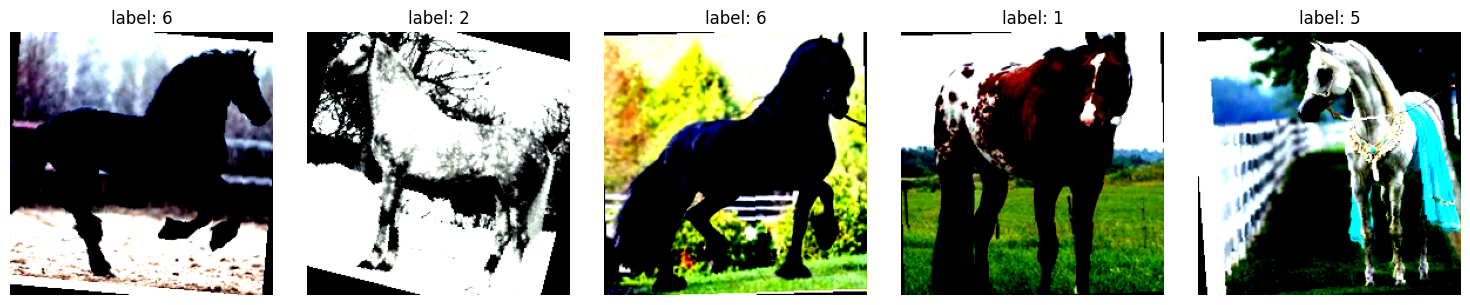

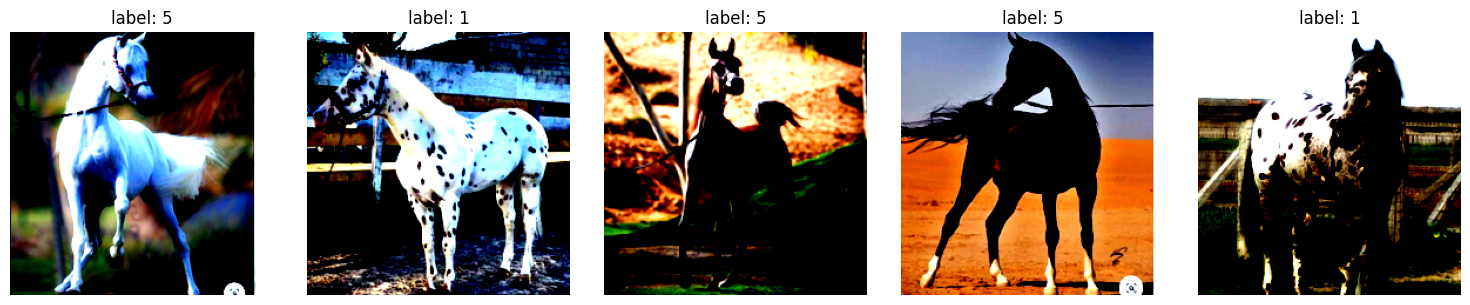

In [18]:
show_random_images(train_ds, n=5)

show_random_images(val_ds, n=5)


### Define Model 

In [19]:
import torch
import torch.nn as nn

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu1 = nn.RReLU()
        self.pool1 = nn.AvgPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu4 = nn.ReLU()

        self.gap = nn.AdaptiveAvgPool2d((1, 1))  
        self.flatten = nn.Flatten()              

        self.fc1 = nn.Linear(128, 512)           
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.bn1(self.pool1(self.relu1(self.conv1(x))))
        x = self.bn2(self.pool2(self.relu2(self.conv2(x))))
        x = self.bn3(self.pool3(self.relu3(self.conv3(x))))
        x = self.relu4(self.conv4(x))

        x = self.gap(x)          
        x = self.flatten(x)

        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x


    def forward(self, x):
        
        # Pass input through the first convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x)

        # Pass feature maps through the second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        # Pass feature maps through the third convolutional block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.bn3(x)

        # Pass feature maps through the third convolutional block
        x = self.conv4(x)
        x = self.relu4(x)
        

        # Flatten the output for the fully connected layers
        x = self.gap(x)
        x = self.flatten(x)

        # Pass the flattened features through the fully connected layers
        
        
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)

        # Return the final output logits
        return x
    


### define Loss and Optimizer

In [21]:
prototype_model = SimpleCNN(num_classes=7)

In [22]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()


optimizer_prototype = optim.Adam(prototype_model.parameters(), lr=0.001)

#### Build one_epoch_training function loop 

In [23]:
import torch

def train_one_epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

#### Build one_epoch_validation function loop 

In [24]:
@torch.no_grad()
def validate_one_epoch(model, val_loader, loss_function, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [25]:
import torch




def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    model.to(device)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print("--- Training Started ---")
    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_function, optimizer, device)
        va_loss, va_acc = validate_one_epoch(model, val_loader, loss_function, device)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(va_loss)
        val_accs.append(va_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}% | "
            f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.2f}%"
        )

    print("--- Finished Training ---")

    metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accs,
        "val_losses": val_losses,
        "val_accuracies": val_accs,
    }

    return model, metrics


In [26]:
trained_proto_model, training_metrics_proto = training_loop(
    model=prototype_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer_prototype,
    num_epochs=15,
    device=device
)


--- Training Started ---
Epoch [1/15] | Train Loss: 1.8665, Train Acc: 24.73% | Val Loss: 1.8861, Val Acc: 29.00%
Epoch [2/15] | Train Loss: 1.6465, Train Acc: 37.10% | Val Loss: 1.7938, Val Acc: 33.00%
Epoch [3/15] | Train Loss: 1.4506, Train Acc: 47.12% | Val Loss: 1.8231, Val Acc: 36.00%
Epoch [4/15] | Train Loss: 1.3542, Train Acc: 51.60% | Val Loss: 1.9686, Val Acc: 25.00%
Epoch [5/15] | Train Loss: 1.3053, Train Acc: 52.24% | Val Loss: 1.7637, Val Acc: 34.00%
Epoch [6/15] | Train Loss: 1.2396, Train Acc: 54.58% | Val Loss: 1.4448, Val Acc: 42.00%
Epoch [7/15] | Train Loss: 1.1942, Train Acc: 57.57% | Val Loss: 1.2962, Val Acc: 57.00%
Epoch [8/15] | Train Loss: 1.1669, Train Acc: 57.57% | Val Loss: 1.3338, Val Acc: 50.00%
Epoch [9/15] | Train Loss: 1.1742, Train Acc: 57.78% | Val Loss: 1.2488, Val Acc: 58.00%
Epoch [10/15] | Train Loss: 1.1213, Train Acc: 62.05% | Val Loss: 1.7386, Val Acc: 42.00%
Epoch [11/15] | Train Loss: 1.0955, Train Acc: 59.70% | Val Loss: 1.3286, Val Acc: 5

### test the model on test set

In [27]:
test_ds = HorseBreedsDataset(test_df, transform=val_transform)

test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0
)


In [28]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def test_model(model, test_loader, loss_function, device, class_names=None):
    model.eval()
    model.to(device)

    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = 100.0 * correct / total

    print("=== Test Results ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

    return {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "y_true": all_labels,
        "y_pred": all_preds,
    }


In [29]:
test_results = test_model(
    model=trained_proto_model,
    test_loader=test_loader,
    loss_function=loss_function,
    device=device,
    
)


=== Test Results ===
Test Loss: 1.1633
Test Accuracy: 55.45%


### show some predictions with the images

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def show_predictions(model, dataset, device, class_names=None, n=5):
    """
    Show n random images with model predictions.
    """
    model.eval()
    model.to(device)

    idxs = random.sample(range(len(dataset)), n)

    plt.figure(figsize=(n * 3, 3))
    for i, idx in enumerate(idxs, 1):
        img, true_label = dataset[idx]

        
        input_img = img.unsqueeze(0).to(device)

       
        outputs = model(input_img)
        _, pred_label = torch.max(outputs, 1)
        pred_label = pred_label.item()

        
        img_show = img.detach().cpu()
        img_show = img_show.permute(1, 2, 0).numpy()

        
        if class_names:
            title = f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}"
        else:
            title = f"Pred: {pred_label} | True: {true_label}"

        plt.subplot(1, n, i)
        plt.imshow(img_show)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


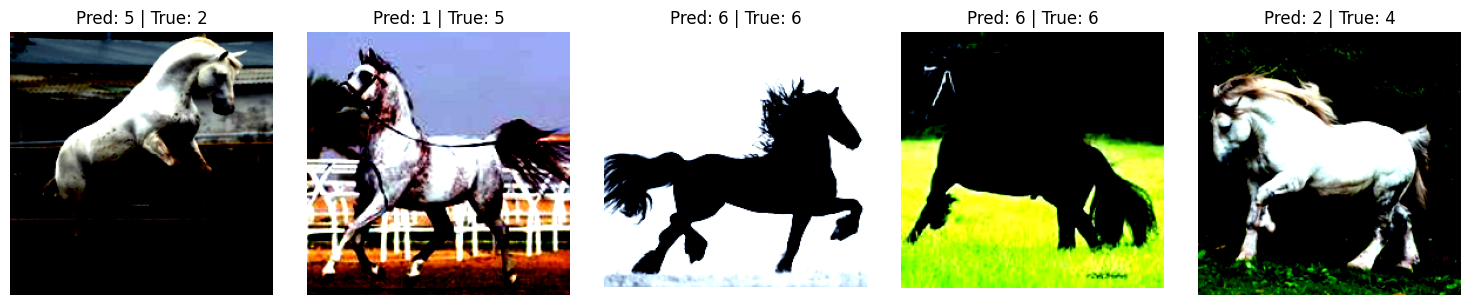

In [31]:
show_predictions(
    model=trained_proto_model,
    dataset=test_ds,
    device=device,
    n=5
)


### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

In [32]:
import matplotlib.pyplot as plt

def plot_train_val_curves(metrics):
    train_losses = metrics["train_losses"]
    val_losses = metrics["val_losses"]
    train_acc = metrics["train_accuracies"]
    val_acc = metrics["val_accuracies"]

    epochs = list(range(1, len(train_losses) + 1))

    # Loss plot
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy plot
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


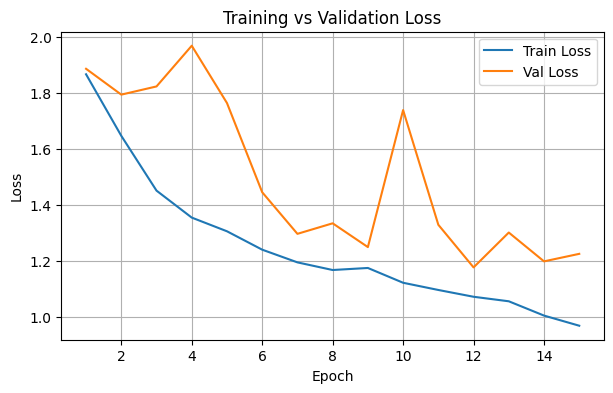

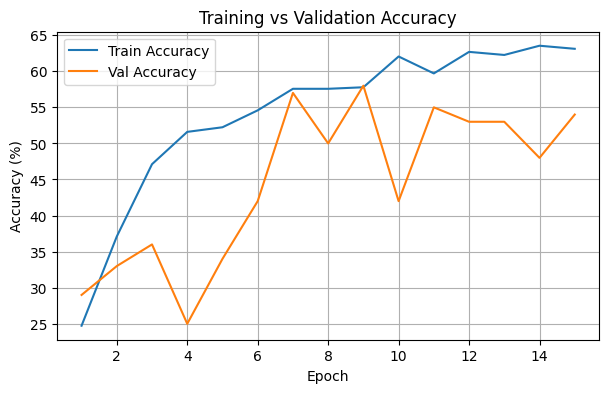

In [33]:
plot_train_val_curves(training_metrics_proto)


## Transfer


In [56]:
from torchvision import datasets, models, transforms

model_ft = models.regnet_y_32gf(weights = models.RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1)

Downloading: "https://download.pytorch.org/models/regnet_y_32gf_swag-04fdfa75.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf_swag-04fdfa75.pth


100%|██████████| 554M/554M [00:06<00:00, 94.0MB/s]


In [ ]:

for param in model_ft.parameters():
    param.requires_grad = False


num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_ft = optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=0.001,
    weight_decay=0.001
)


In [58]:
model_ft, training_metrics_proto = training_loop(
    model=model_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer_ft,
    num_epochs=15,
    device=device
)

--- Training Started ---
Epoch [1/15] | Train Loss: 1.8680, Train Acc: 34.33% | Val Loss: 1.1815, Val Acc: 60.00%
Epoch [2/15] | Train Loss: 0.9260, Train Acc: 71.22% | Val Loss: 0.6536, Val Acc: 81.00%
Epoch [3/15] | Train Loss: 0.6651, Train Acc: 77.40% | Val Loss: 0.5503, Val Acc: 81.00%
Epoch [4/15] | Train Loss: 0.4637, Train Acc: 85.71% | Val Loss: 0.4999, Val Acc: 86.00%
Epoch [5/15] | Train Loss: 0.3173, Train Acc: 90.19% | Val Loss: 0.4225, Val Acc: 83.00%
Epoch [6/15] | Train Loss: 0.2917, Train Acc: 91.04% | Val Loss: 0.4336, Val Acc: 88.00%
Epoch [7/15] | Train Loss: 0.2432, Train Acc: 92.96% | Val Loss: 0.3902, Val Acc: 87.00%
Epoch [8/15] | Train Loss: 0.2320, Train Acc: 94.67% | Val Loss: 0.3845, Val Acc: 84.00%
Epoch [9/15] | Train Loss: 0.1822, Train Acc: 95.52% | Val Loss: 0.4278, Val Acc: 84.00%
Epoch [10/15] | Train Loss: 0.1963, Train Acc: 94.46% | Val Loss: 0.3792, Val Acc: 85.00%
Epoch [11/15] | Train Loss: 0.1798, Train Acc: 95.74% | Val Loss: 0.3783, Val Acc: 8

In [59]:
test_results = test_model(
    model=model_ft,
    test_loader=test_loader,
    loss_function=loss_function,
    device=device,
    
)


=== Test Results ===
Test Loss: 0.3716
Test Accuracy: 85.15%


### Load the model

In [ ]:
from google.colab import files
uploaded = files.upload()  
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7

model_ft = models.regnet_y_32gf(weights=None)
model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)

model_ft.load_state_dict(torch.load("regnet_y_32gf_horses.pth", map_location=device))
model_ft = model_ft.to(device)
model_ft.eval()
